# FluiditySaramitoLocal: Flow Curve Analysis

**Gateway Notebook:** Elastoviscoplastic (EVP) thixotropic model with tensorial stress.

## What is the Fluidity-Saramito EVP Model?

**FluiditySaramitoLocal** combines **Saramito tensorial viscoelasticity** with **fluidity thixotropy** to capture elastoviscoplastic materials where structure, elasticity, and yielding are tightly coupled. This enables:

- **Tensorial stress**: Full $\boldsymbol{\tau} = [\tau_{xx}, \tau_{yy}, \tau_{xy}]$ evolution via upper-convected Maxwell
- **Von Mises yield**: $\alpha = \max(0, 1 - \tau_y/|\boldsymbol{\tau}|)$ explicit plasticity criterion
- **Normal stresses**: Predicts $N_1 = \tau_{xx} - \tau_{yy}$ from UCM backbone (Fluidity alone cannot)
- **Thixotropic yield stress**: Optional "full" coupling makes $\tau_y(f)$ increase during aging

**Key equation (tensorial stress evolution):**
$$
\lambda \overset{\nabla}{\boldsymbol{\tau}} + \alpha(\boldsymbol{\tau})\boldsymbol{\tau} = 2\eta_p \mathbf{D}
$$
where $\lambda = 1/f$ (fluidity-dependent relaxation time) and $\alpha$ activates only when $|\boldsymbol{\tau}| > \tau_y$.

**Materials:** Carbopol gels, concentrated emulsions (mayonnaise), polymer gels with yield, cosmetics, waxy crude oils.

**Coupling architectures:**
- **Minimal** (this notebook): $\lambda = 1/f$ only → fewer parameters, most identifiable
- **Full**: $\lambda = 1/f$ + $\tau_y(f)$ aging yield → captures wait-time dependent startup

**vs FluidityLocal:** Tensorial stress → can predict $N_1$, better for extensional flows, explicit von Mises yield surface.

> **Handbook:** [Saramito EVP](../../docs/source/models/fluidity/saramito_evp.rst) — Coupling design, parameter guide, UCM theory

---

## Learning Objectives

1. **Tensorial Elastoviscoplasticity**: Understand the Saramito tensorial framework with upper-convected Maxwell (UCM) backbone
2. **Von Mises Yield Criterion**: Learn how the von Mises criterion α = max(0, 1 - τ_y/|τ|) controls plasticity
3. **Coupling Modes**: Compare "minimal" (λ = 1/f only) vs "full" (λ + τ_y(f) aging yield) coupling strategies
4. **Flow Curve Prediction**: Extract Herschel-Bulkley-like parameters (τ_y, K, n) from steady shear
5. **NLSQ + Bayesian Workflow**: Use NLSQ warm-start for efficient Bayesian inference with ArviZ diagnostics

In [1]:
# Uncomment and run in Google Colab
# !pip install rheojax nlsq numpyro arviz -q

---

## Setup and Imports

In [2]:
import os
import sys

%matplotlib inline
# JAX configuration (MUST be imported before any JAX usage)
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax
from rheojax.utils.metrics import compute_fit_quality

jax, jnp = safe_import_jax()

# RheoJAX imports
# Standard libraries
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from rheojax.core import RheoData
from rheojax.logging import configure_logging, get_logger
from rheojax.models.fluidity import FluiditySaramitoLocal
from rheojax.pipeline import BayesianPipeline

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Set random seed for reproducibility
np.random.seed(42)

# Matplotlib styling
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print(f"JAX devices: {jax.devices()}")
print(f"JAX version: {jax.__version__}")

# Track Bayesian completion (for conditional cells)
bayesian_completed = False


JAX devices: [CpuDevice(id=0)]
JAX version: 0.8.3


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

---

## Theory: Saramito Tensorial Elastoviscoplasticity

### Governing Equations

The FluiditySaramitoLocal model combines:

1. **Tensorial Stress Evolution** (Upper-Convected Maxwell with von Mises yield):
   $$
   \lambda \hat{\nabla}\boldsymbol{\tau} + \alpha(\boldsymbol{\tau}) \boldsymbol{\tau} = 2\eta_p \mathbf{D}
   $$
   where:
   - $\boldsymbol{\tau} = [\tau_{xx}, \tau_{yy}, \tau_{xy}]$ is the stress tensor
   - $\hat{\nabla}$ is the upper-convected derivative
   - $\mathbf{D}$ is the rate-of-deformation tensor
   - $\alpha(\boldsymbol{\tau}) = \max\left(0, 1 - \frac{\tau_y}{|\boldsymbol{\tau}|}\right)$ is the von Mises yield function
   - $|\boldsymbol{\tau}| = \sqrt{\tau_{xx}^2 + \tau_{yy}^2 + 2\tau_{xy}^2}$ is the von Mises stress

2. **Fluidity Evolution**:
   $$
   \frac{df}{dt} = \frac{f_{\text{age}} - f}{t_a} + b|\dot{\gamma}|^n (f_{\text{flow}} - f)
   $$

### Coupling Modes

The fluidity parameter $f$ couples to stress through:

1. **Minimal Coupling** (`coupling="minimal"`):
   - $\lambda = 1/f$ (fluidity controls relaxation time)
   - $\tau_y = \text{const}$ (fixed yield stress)
   - Simpler model, fewer parameters

2. **Full Coupling** (`coupling="full"`):
   - $\lambda = 1/f$ (fluidity controls relaxation time)
   - $\tau_y = \tau_{y,0} + (\tau_{y,\text{age}} - \tau_{y,0})(1 - f)$ (aging yield stress)
   - More physical, captures yield stress evolution with structure

### Flow Curve Behavior

At steady state ($df/dt = 0$, $\hat{\nabla}\boldsymbol{\tau} = 0$):
$$
\sigma(\dot{\gamma}) \approx \tau_y + K \dot{\gamma}^n
$$
(Herschel-Bulkley-like, with $K = 2\eta_p$ and $n$ from power-law index)

### Normal Stress Differences

The tensorial formulation enables prediction of:
$$
N_1 = \tau_{xx} - \tau_{yy} = 2\eta_p \lambda \dot{\gamma}^2
$$
(UCM backbone gives positive $N_1$, $N_2 = 0$)

---

## Generate Synthetic Flow Curve Data

We'll create synthetic emulsion flow curve data with:
- Yield stress transition
- Shear-thinning behavior
- Measurement noise

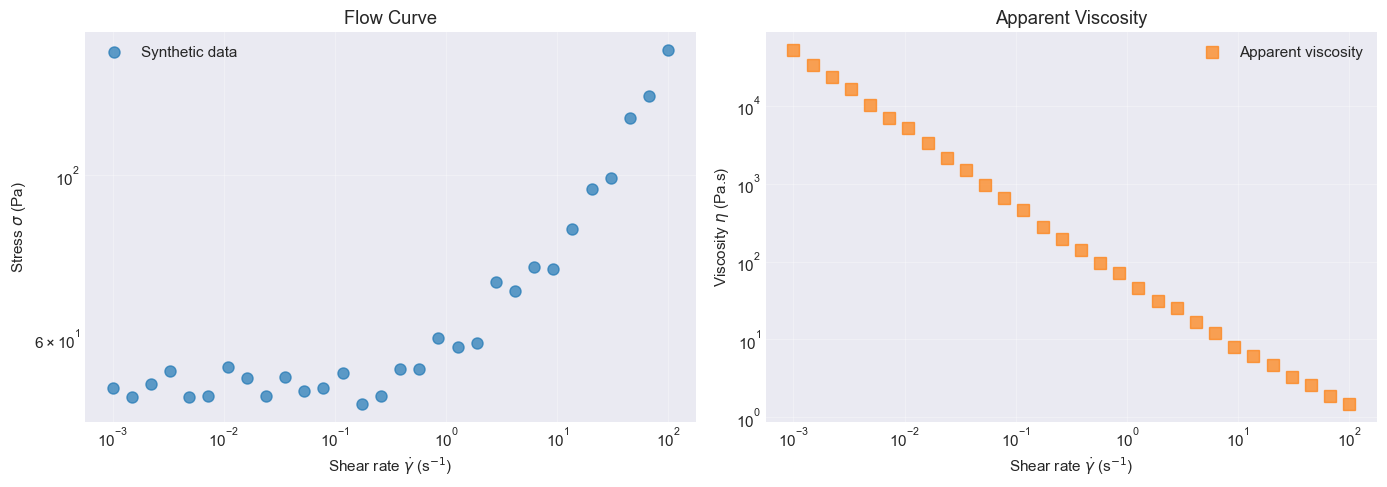

Data points: 30
Shear rate range: 1.000e-03 - 1.000e+02 s^-1
Stress range: 48.99 - 147.81 Pa


In [4]:
def generate_flow_curve_data(
    gamma_dot_range=(1e-3, 1e2),
    n_points=30,
    tau_y=50.0,
    K=10.0,
    n=0.5,
    noise_level=0.05
):
    """
    Generate synthetic Herschel-Bulkley flow curve.
    
    Parameters
    ----------
    gamma_dot_range : tuple
        Min and max shear rate (s^-1)
    n_points : int
        Number of data points
    tau_y : float
        Yield stress (Pa)
    K : float
        Consistency (Pa.s^n)
    n : float
        Flow index (dimensionless)
    noise_level : float
        Relative noise (0.05 = 5%)
    """
    # Log-spaced shear rates
    gamma_dot = np.logspace(
        np.log10(gamma_dot_range[0]),
        np.log10(gamma_dot_range[1]),
        n_points
    )
    
    # Herschel-Bulkley model
    stress = tau_y + K * gamma_dot**n
    
    # Add multiplicative noise
    noise = np.random.normal(1.0, noise_level, size=stress.shape)
    stress_noisy = stress * noise
    
    return gamma_dot, stress_noisy


# Generate data
gamma_dot, stress = generate_flow_curve_data(
    gamma_dot_range=(1e-3, 1e2),
    n_points=30,
    tau_y=50.0,
    K=10.0,
    n=0.5,
    noise_level=0.05
)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flow curve
axes[0].loglog(gamma_dot, stress, 'o', markersize=8, alpha=0.7, label='Synthetic data')
axes[0].set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
axes[0].set_ylabel(r'Stress $\sigma$ (Pa)')
axes[0].set_title('Flow Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Apparent viscosity
eta_app = stress / gamma_dot
axes[1].loglog(gamma_dot, eta_app, 's', markersize=8, alpha=0.7, color='C1', label='Apparent viscosity')
axes[1].set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
axes[1].set_ylabel(r'Viscosity $\eta$ (Pa.s)')
axes[1].set_title('Apparent Viscosity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: {gamma_dot.min():.3e} - {gamma_dot.max():.3e} s^-1")
print(f"Stress range: {stress.min():.2f} - {stress.max():.2f} Pa")

---

## NLSQ Fitting: Compare Coupling Modes

We'll fit both coupling modes and compare fit quality.

In [5]:
# Create RheoData for reference (not used in fit)
rheo_data = RheoData(
    x=gamma_dot,
    y=stress,
    initial_test_mode='flow_curve'
)

# Fit minimal coupling
model_minimal = FluiditySaramitoLocal(coupling="minimal")
model_minimal.fit(gamma_dot, stress, test_mode='flow_curve', method='scipy')

# Compute fit quality for minimal coupling
stress_pred_minimal = np.array(model_minimal.predict(gamma_dot, test_mode='flow_curve')).flatten()
metrics_minimal = compute_fit_quality(stress, stress_pred_minimal)

print("\n" + "="*60)
print("MINIMAL COUPLING FIT")
print("="*60)
print(f"R² = {metrics_minimal['R2']:.6f}")
print(f"RMSE = {metrics_minimal['RMSE']:.4f}")
print(f"\nFitted parameters:")
for name in model_minimal.parameters.keys():
    value = model_minimal.parameters.get_value(name)
    print(f"  {name:12s} = {value:.6e}")

# Fit full coupling
model_full = FluiditySaramitoLocal(coupling="full")
model_full.fit(gamma_dot, stress, test_mode='flow_curve', method='scipy')

# Compute fit quality for full coupling
stress_pred_full = np.array(model_full.predict(gamma_dot, test_mode='flow_curve')).flatten()
metrics_full = compute_fit_quality(stress, stress_pred_full)

print("\n" + "="*60)
print("FULL COUPLING FIT")
print("="*60)
print(f"R² = {metrics_full['R2']:.6f}")
print(f"RMSE = {metrics_full['RMSE']:.4f}")
print(f"\nFitted parameters:")
for name in model_full.parameters.keys():
    value = model_full.parameters.get_value(name)
    print(f"  {name:12s} = {value:.6e}")

# Compare
print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"ΔR² = {metrics_full['R2'] - metrics_minimal['R2']:.6f}")
print(f"ΔRMSE = {metrics_full['RMSE'] - metrics_minimal['RMSE']:.4f}")

18:56:59 | INFO     | rheojax.models.fluidity.saramito.local | model_fit started


18:56:59 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=10


18:56:59 | INFO     | rheojax.models.fluidity.saramito.local | model_fit completed


18:56:59 | INFO     | rheojax.core.base | Fit completed | model=FluiditySaramitoLocal | fitted=True | R2=0.9886 | data_shape=(30,)


18:56:59 | INFO     | rheojax.models.fluidity.saramito.local | model_fit started


18:56:59 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=12



MINIMAL COUPLING FIT
R² = 0.988592
RMSE = 2.7110

Fitted parameters:
  G            = 1.000000e+01
  eta_s        = 1.620470e+01
  tau_y0       = 5.048654e+01
  K_HB         = 8.022388e+00
  n_HB         = 5.467897e-01
  f_age        = 6.765337e-05
  f_flow       = 6.765337e-01
  t_a          = 1.000000e+01
  b            = 1.000000e+00
  n_rej        = 1.000000e+00


18:56:59 | INFO     | rheojax.models.fluidity.saramito.local | model_fit completed


18:56:59 | INFO     | rheojax.core.base | Fit completed | model=FluiditySaramitoLocal | fitted=True | R2=0.9905 | data_shape=(30,)



FULL COUPLING FIT
R² = 0.990502
RMSE = 2.4737

Fitted parameters:
  G            = 1.000000e+01
  eta_s        = 1.480171e+01
  tau_y0       = 3.829093e+01
  K_HB         = 1.204751e+01
  n_HB         = 4.597433e-01
  f_age        = 3.463452e-03
  f_flow       = 6.598155e-01
  t_a          = 1.376796e+02
  b            = 1.618600e+00
  n_rej        = 2.999993e+00
  tau_y_coupling = 7.109418e+00
  m_yield      = 1.000000e-01

COMPARISON
ΔR² = 0.001909
ΔRMSE = -0.2372


---

## Visualize Fits

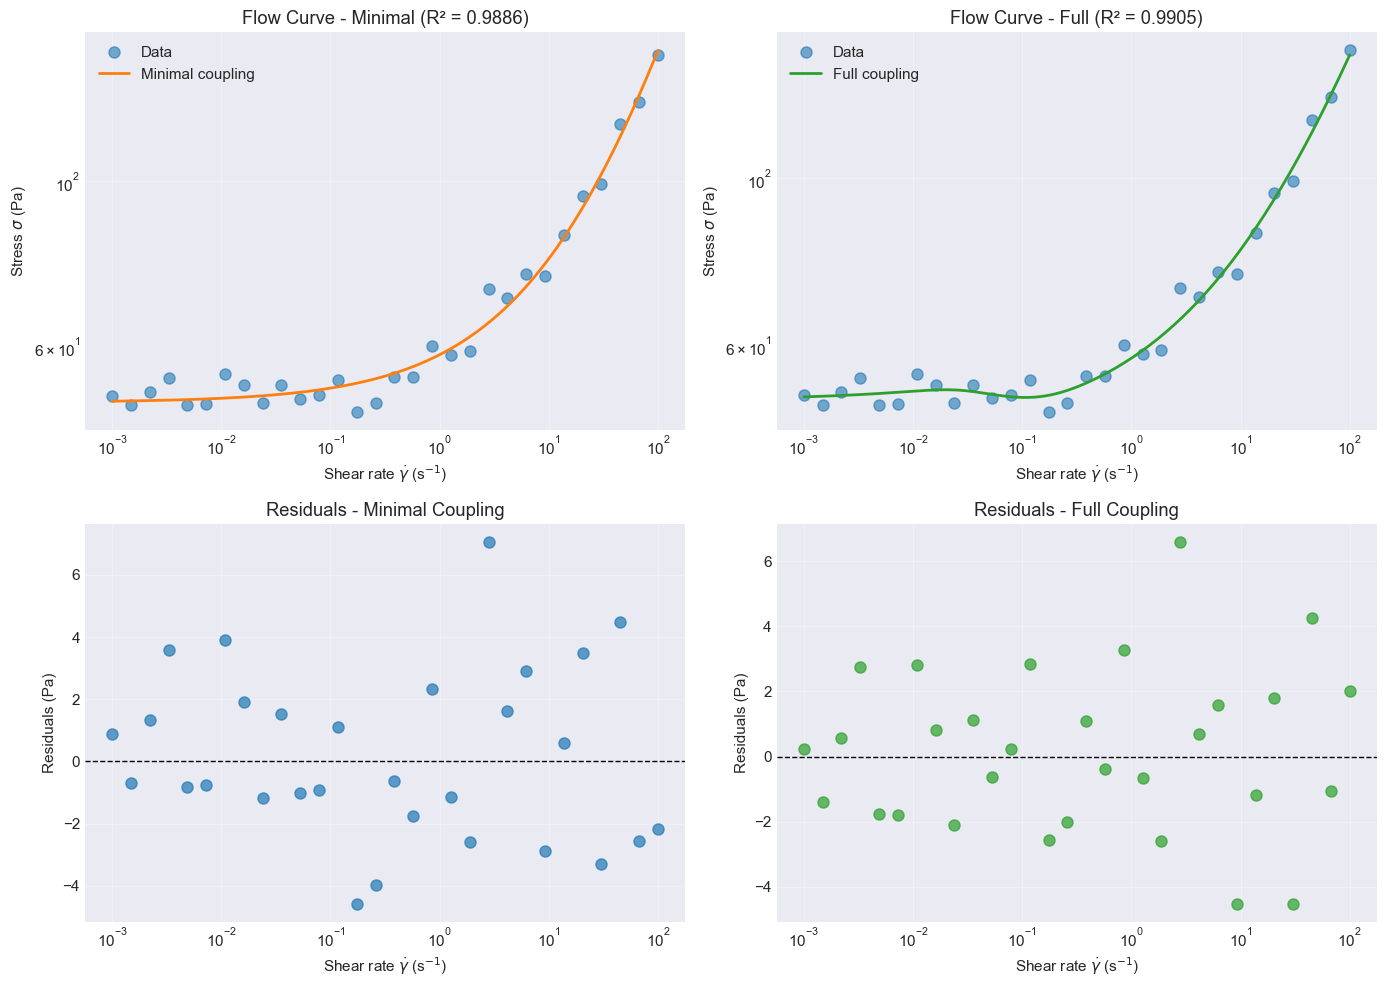

In [6]:
# Generate predictions
gamma_dot_pred = np.logspace(np.log10(gamma_dot.min()), np.log10(gamma_dot.max()), 200)
stress_curve_minimal = np.array(model_minimal.predict(gamma_dot_pred, test_mode='flow_curve')).flatten()
stress_curve_full = np.array(model_full.predict(gamma_dot_pred, test_mode='flow_curve')).flatten()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Flow curve - minimal
axes[0, 0].loglog(gamma_dot, stress, 'o', markersize=8, alpha=0.6, label='Data')
axes[0, 0].loglog(gamma_dot_pred, stress_curve_minimal, '-', linewidth=2, label='Minimal coupling')
axes[0, 0].set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
axes[0, 0].set_ylabel(r'Stress $\sigma$ (Pa)')
axes[0, 0].set_title(f"Flow Curve - Minimal (R² = {metrics_minimal['R2']:.4f})")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Flow curve - full
axes[0, 1].loglog(gamma_dot, stress, 'o', markersize=8, alpha=0.6, label='Data')
axes[0, 1].loglog(gamma_dot_pred, stress_curve_full, '-', linewidth=2, color='C2', label='Full coupling')
axes[0, 1].set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
axes[0, 1].set_ylabel(r'Stress $\sigma$ (Pa)')
axes[0, 1].set_title(f"Flow Curve - Full (R² = {metrics_full['R2']:.4f})")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residuals - minimal
residuals_minimal = stress - stress_pred_minimal
axes[1, 0].semilogx(gamma_dot, residuals_minimal, 'o', markersize=8, alpha=0.7)
axes[1, 0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
axes[1, 0].set_ylabel('Residuals (Pa)')
axes[1, 0].set_title('Residuals - Minimal Coupling')
axes[1, 0].grid(True, alpha=0.3)

# Residuals - full
residuals_full = stress - stress_pred_full
axes[1, 1].semilogx(gamma_dot, residuals_full, 'o', markersize=8, alpha=0.7, color='C2')
axes[1, 1].axhline(0, color='k', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
axes[1, 1].set_ylabel('Residuals (Pa)')
axes[1, 1].set_title('Residuals - Full Coupling')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

---

## Bayesian Inference with NLSQ Warm-Start

We'll use the better-fitting model for Bayesian analysis.

In [7]:
# Select best model

# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference')
    bayesian_completed = False
else:
    if metrics_full['R2'] > metrics_minimal['R2']:
        best_model = model_full
        coupling_mode = "full"
        best_r2 = metrics_full['R2']
        print("Using FULL coupling for Bayesian inference")
    else:
        best_model = model_minimal
        coupling_mode = "minimal"
        best_r2 = metrics_minimal['R2']
        print("Using MINIMAL coupling for Bayesian inference")

    print(f"\nNLSQ R² = {best_r2:.6f}")
    print("\nRunning Bayesian inference (NUTS)...")
    print("This may take 1-3 minutes...")

    # Bayesian fit with NLSQ warm-start

    # FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
    FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
    _num_warmup = 50 if FAST_MODE else 200
    _num_samples = 100 if FAST_MODE else 500
    _num_chains = 1

    bayesian_result = best_model.fit_bayesian(
        gamma_dot, stress,
        test_mode='flow_curve',
        num_warmup=_num_warmup,
        num_samples=_num_samples,
        num_chains=4,
        seed=42
    )

    print("\n" + "="*60)
    print("BAYESIAN INFERENCE COMPLETE")
    print("="*60)

    # Get credible intervals
    intervals = best_model.get_credible_intervals(
        bayesian_result.posterior_samples,
        credibility=0.95
    )

    print("\n95% Credible Intervals:")
    for param, (lower, upper) in intervals.items():
        median = np.median(bayesian_result.posterior_samples[param])
        print(f"  {param:12s}: {median:.4e} [{lower:.4e}, {upper:.4e}]")

    bayesian_completed = True



FAST_MODE: Skipping Bayesian inference


---

## ArviZ Diagnostics

Check MCMC convergence and posterior quality.

In [8]:
if bayesian_completed:
    # Convert to ArviZ InferenceData
    idata = az.from_dict(
        posterior={
            k: (v.reshape(4, -1) if v.ndim == 1 else v) 
            for k, v in bayesian_result.posterior_samples.items()
        }
    )

    # Compute diagnostics
    print("\n" + "="*60)
    print("MCMC DIAGNOSTICS")
    print("="*60)

    summary = az.summary(idata, hdi_prob=0.95)
    print(summary)

    # Check convergence
    r_hat_max = summary['r_hat'].max()
    ess_bulk_min = summary['ess_bulk'].min()
    ess_tail_min = summary['ess_tail'].min()

    print("\n" + "="*60)
    print("CONVERGENCE CHECKS")
    print("="*60)
    print(f"Max R-hat: {r_hat_max:.4f} {'✓ PASS' if r_hat_max < 1.01 else '✗ FAIL (>1.01)'}")
    print(f"Min ESS (bulk): {ess_bulk_min:.0f} {'✓ PASS' if ess_bulk_min > 400 else '✗ WARNING (<400)'}")
    print(f"Min ESS (tail): {ess_tail_min:.0f} {'✓ PASS' if ess_tail_min > 400 else '✗ WARNING (<400)'}")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


---

## Posterior Visualization

In [9]:
if bayesian_completed:
    display_arviz_diagnostics(bayesian_result, list(best_model.parameters.keys()), fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


---

## Posterior Predictive Check

In [10]:
if bayesian_completed:
    fig, ax = plot_posterior_predictive(
        gamma_dot, stress, best_model, bayesian_result,
        test_mode="flow_curve",
        param_names=param_names,
        log_scale=True,
        xlabel="Shear rate [1/s]",
        ylabel="Stress [Pa]",
        title="Posterior Predictive Check",
    )
    plt.close("all")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


---

## Save Results

In [11]:
if bayesian_completed:
    # Create output directory
    output_dir = Path('../outputs/fluidity/saramito_local/flow_curve')
    output_dir.mkdir(parents=True, exist_ok=True)

    # Collect NLSQ parameters from both models
    params_minimal = {name: model_minimal.parameters.get_value(name) for name in model_minimal.parameters.keys()}
    params_full = {name: model_full.parameters.get_value(name) for name in model_full.parameters.keys()}

    # Save NLSQ results (both coupling modes)
    np.savez(
        output_dir / 'nlsq_results.npz',
        gamma_dot=gamma_dot,
        stress=stress,
        gamma_dot_pred=gamma_dot_pred,
        stress_minimal=stress_curve_minimal,
        stress_full=stress_curve_full,
        r2_minimal=metrics_minimal['R2'],
        r2_full=metrics_full['R2'],
        rmse_minimal=metrics_minimal['RMSE'],
        rmse_full=metrics_full['RMSE'],
        params_minimal=params_minimal,
        params_full=params_full
    )

    # Save Bayesian results
    np.savez(
        output_dir / f'bayesian_results_{coupling_mode}.npz',
        coupling_mode=coupling_mode,
        posterior_samples=bayesian_result.posterior_samples,
        credible_intervals=intervals,
        pred_median=pred_median,
        pred_lower=pred_lower,
        pred_upper=pred_upper
    )

    # Save ArviZ InferenceData
    idata.to_netcdf(output_dir / f'arviz_data_{coupling_mode}.nc')

    print(f"\nResults saved to: {output_dir.absolute()}")
    print("Files:")
    print("  - nlsq_results.npz (both coupling modes)")
    print(f"  - bayesian_results_{coupling_mode}.npz")
    print(f"  - arviz_data_{coupling_mode}.nc")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


---

## Key Takeaways

### 1. Tensorial Formulation
- FluiditySaramitoLocal uses **upper-convected Maxwell** backbone for tensorial stress evolution
- Enables prediction of **normal stress differences** ($N_1 = 2\eta_p \lambda \dot{\gamma}^2$)
- More realistic than scalar models for complex flows

### 2. Von Mises Yield Criterion
- $\alpha = \max(0, 1 - \tau_y/|\boldsymbol{\tau}|)$ smoothly transitions between elastic and plastic regimes
- Avoids discontinuities in stress evolution
- Physically motivated for yield stress fluids

### 3. Coupling Mode Selection

**Minimal Coupling** (`coupling="minimal"`):
- Use when: Material has **fixed yield stress** independent of structure
- Simpler model (fewer parameters)
- Faster convergence in NLSQ and Bayesian inference
- Example: Emulsions with constant droplet interactions

**Full Coupling** (`coupling="full"`):
- Use when: Material shows **yield stress evolution** during aging/rejuvenation
- More physical for thixotropic materials
- Required for modeling startup overshoot and creep bifurcation
- Example: Colloidal gels with structure-dependent jamming

### 4. Flow Curve Interpretation
- Steady-state flow curves exhibit **Herschel-Bulkley** behavior: $\sigma \approx \tau_y + K\dot{\gamma}^n$
- Yield stress $\tau_y$ from von Mises criterion
- Consistency $K \approx 2\eta_p$ from viscous stress
- Power-law index $n$ from shear-thinning (if present)

### 5. NLSQ + Bayesian Workflow
- **NLSQ warm-start is critical** for Bayesian convergence (R-hat <1.01, ESS >400)
- Use **4 chains** for production-ready diagnostics
- **ArviZ** essential for checking:
  - Convergence (R-hat, ESS)
  - Posterior geometry (pair plots)
  - Parameter uncertainty (forest plots)

### 6. Next Steps
- **Startup Transients**: Use `simulate_startup()` to capture stress overshoot
- **Creep Tests**: Use `simulate_creep()` to study viscosity bifurcation
- **LAOS**: Use `simulate_laos()` for nonlinear oscillatory response
- **Nonlocal Model**: `FluiditySaramitoNonlocal` for shear banding analysis